In [1]:
"""
Author: Andrew Q. Pham, Victor Shia
Email: apham@g.hmc.edu, vshia@g.hmc.edu
Date of Creation: 2/26/20
Description:
    Particle filter implementation to filtering localization estimate
    This code is for teaching purposes for HMC ENGR205 System Simulation Lab 4
    Student code version with parts omitted.
"""


'\nAuthor: Andrew Q. Pham, Victor Shia\nEmail: apham@g.hmc.edu, vshia@g.hmc.edu\nDate of Creation: 2/26/20\nDescription:\n    Particle filter implementation to filtering localization estimate\n    This code is for teaching purposes for HMC ENGR205 System Simulation Lab 4\n    Student code version with parts omitted.\n'

In [2]:
from utils import *
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import shelve
import scipy.stats

In [3]:
# RANDOM OBJECTS

rng = np.random.default_rng(0)
meas_rv = scipy.stats.multivariate_normal(mean = np.array([0,0,0]), cov = meas_cov)

In [4]:
def propagate_state(x_t_prev, noiseless_u_t):
    """Propagate/predict the state based on chosen motion model

    Parameters:
    x_t_prev (np.array)  -- the previous state estimate, P x N
    u_t (np.array)       -- the current control input, P x U

    Returns:
    x_bar_t (np.array)   -- the predicted state
    """
    """STUDENT CODE START"""
    x_vel_prev = x_t_prev[:,2]
    y_vel_prev = x_t_prev[:,3]
    yaw_prev = x_t_prev[:,4]
    
    x_acc = noiseless_u_t[0]
    yaw_vel = noiseless_u_t[1]
    
    x_bar_t = np.zeros_like(x_t_prev)

    #Propagation does not change the weights
    x_bar_t[:,0] = x_vel_prev * DT
    x_bar_t[:,1] = y_vel_prev * DT
    x_bar_t[:,2] = x_acc * np.cos(yaw_prev) * DT
    x_bar_t[:,3] = x_acc * np.sin(yaw_prev) * DT
    x_bar_t[:,4] = yaw_vel * DT
    x_bar_t += x_t_prev
                                   
    """STUDENT CODE END"""
    return x_bar_t

In [5]:
def calc_meas_prediction(x_bar_t):
    """Calculate predicted measurement based on the predicted state

    Parameters:
    x_bar_t (np.array)  -- the predicted state

    Returns:
    z_bar_t (np.array)  -- the predicted measurement
    """

    """STUDENT CODE START"""
    z_bar_t = np.zeros((PARTICLES, MEASUREMENTS))
    
    z_bar_t[:,0] = x_bar_t[:,0]
    z_bar_t[:,1] = x_bar_t[:,1]
    z_bar_t[:,2] = x_bar_t[:,4]
    """STUDENT CODE END"""

    return z_bar_t

In [6]:
def prediction_and_correction_step(x_t_prev, u_t, z_t):
    """Compute the prediction and correction (re-weighting) for the PF

    Parameters:
    x_t_prev (np.array)         -- the previous state estimate
    u_t (np.array)              -- the control input
    z_t (np.array)              -- the current measurement

    Returns:
    x_bar_t (np.array)          -- the predicted state estimate of time t
    """

    """STUDENT CODE START"""
    
    # Adding noise before propagation
    
    x_acc, yaw_vel = u_t #2x1
    
    # Prediction step
    x_bar_t = propagate_state(x_t_prev, u_t) # PARTICLES x STATES
    
    noisy_x_bar_t = x_bar_t
    noisy_x_bar_t[:,0] += np.random.normal(loc = 0, scale = process_noise['x'], size = PARTICLES)
    noisy_x_bar_t[:,1] += np.random.normal(loc = 0, scale = process_noise['y'], size = PARTICLES)
    noisy_x_bar_t[:,4] += np.random.normal(loc = 0, scale = process_noise['theta'], size = PARTICLES)
    # Correction
    z_bar_t = calc_meas_prediction(noisy_x_bar_t) # PARTICLES x MEASUREMENTS
    
    meas_diff = z_bar_t - z_t.reshape(1,MEASUREMENTS) # PARTICLES x MEASUREMENTS
    new_weights = meas_rv.pdf(meas_diff) # PARTICLES x 1
    new_weights /= np.sum(new_weights)
    
    x_bar_t[:,5] = new_weights
    """STUDENT CODE END"""

    return x_bar_t

In [7]:
def resample_step(x_bar_t):
    """Ressampling step for the PF

    Parameters:
    x_bar_t       (np.array)    -- the predicted state estimate of time t
    """

    """STUDENT CODE START"""
    
    x_est_t = rng.choice(a = x_bar_t, 
                         size = PARTICLES, 
                         p = x_bar_t[:,5],
                         axis = 0)
    x_est_t[:,5] = 1/PARTICLES
    
    """STUDENT CODE END"""

    return x_est_t

In [8]:
def moving_average(x, window = 10):
    return np.convolve(x, 1.0 * np.ones(window) / window, 'full')

In [9]:
filepath = "../E205_Lab_03/logs/"
filename = "2020_2_26__16_59_7"
# filename = "2020_2_26__17_21_59"
data, is_filtered = load_data(filepath + filename)

# Save filtered data so don't have to process unfiltered data everytime
if not is_filtered:
    data = filter_data(data)
    save_data(f_data, filepath+filename+"_filtered.csv")

In [10]:
# Load data into variables
x_lidar = np.array(data["X"])
y_lidar = np.array(data["Y"])
z_lidar = data["Z"]
time_stamps = data["Time Stamp"]
lat_gps = np.array(data["Latitude"])
lon_gps = np.array(data["Longitude"])
yaw_lidar = np.array(data["Yaw"])
pitch_lidar = data["Pitch"]
roll_lidar = data["Roll"]
x_acc = np.array(data["AccelX"])
y_acc = np.array(data["AccelY"])

lat_origin = lat_gps[0]
lon_origin = lon_gps[0]

### TRANSFORMS/EDITS/OVERWRITES
yaw_lidar = (np.array(yaw_lidar) * -1) * np.pi/180
yaw_lidar = our_wrap_to_pi(yaw_lidar)

time_stamps = np.arange(len(time_stamps)) * 0.1

window_size = 3

x_acc = np.convolve(np.array(x_acc), np.ones(3)/3, mode = 'same')
#y_acc = np.convolve(np.array(y_acc), np.ones(3)/3, mode = 'same')

z_x = 5 - (y_lidar*np.cos(yaw_lidar) + x_lidar*np.sin(yaw_lidar))
z_y = -5 - (y_lidar*np.sin(yaw_lidar) - x_lidar*np.cos(yaw_lidar))
z_yaw = yaw_lidar

yaw_vel = our_wrap_to_pi(yaw_lidar[1:]-yaw_lidar[:-1]) / DT
yaw_vel = np.append(yaw_vel, yaw_vel[-1])

In [11]:
#  Initialize filter
"""STUDENT CODE START"""

state_estimates = np.zeros((PARTICLES, STATES, len(time_stamps)))
gps_estimates = np.empty((2, len(time_stamps)))

state_est_t_prev = np.zeros((PARTICLES, STATES))
state_est_t_prev[:,0] = rng.uniform(-1, 1, size = PARTICLES)
state_est_t_prev[:,1] = rng.uniform(-1, 1, size = PARTICLES)
state_est_t_prev[:,2] = rng.uniform(-0.1, 0.1, size = PARTICLES)
state_est_t_prev[:,3] = rng.uniform(-0.1, 0.1, size = PARTICLES)
state_est_t_prev[:,4] = rng.uniform(-0.2, 0.2, size = PARTICLES)
state_est_t_prev[:,5] = 1/PARTICLES 
"""STUDENT CODE END"""

#  Run filter over data
for time_ind, _ in enumerate(time_stamps):
    # Get control input
    """STUDENT CODE START"""
    u_t = np.array([x_acc[time_ind], yaw_vel[time_ind]])
    z_t = np.array([z_x[time_ind], z_y[time_ind], z_yaw[time_ind]])
    """STUDENT CODE END"""

    # Prediction Step
    state_pred_t = prediction_and_correction_step(state_est_t_prev, u_t, z_t)
    
    state_est_t = resample_step(state_pred_t)

    #  For clarity sake/teaching purposes, we explicitly update t->(t-1)
    state_est_t_prev = state_est_t

    # Log Data
    state_estimates[:, :, time_ind] = state_est_t

    x_gps, y_gps = convert_gps_to_xy(lat_gps=lat_gps[time_ind],
                                     lon_gps=lon_gps[time_ind],
                                     lat_origin=lat_origin,
                                     lon_origin=lon_origin)
    gps_estimates[:, time_ind] = np.array([x_gps, y_gps])

# for key in dir():
#     try:
#         my_shelf[key] = eval(key)
#     except Exception:
#         #
#         # __builtins__, my_shelf, and imported modules can not be shelved.
#         #
#         print('ERROR shelving: {0}'.format(key))
# my_shelf.close()


"""STUDENT CODE START"""
# Plot here
"""STUDENT CODE END"""
#return 0

'STUDENT CODE END'

In [25]:
pf_x, pf_y, _, _, _, _ = np.average(state_estimates, axis = 0)

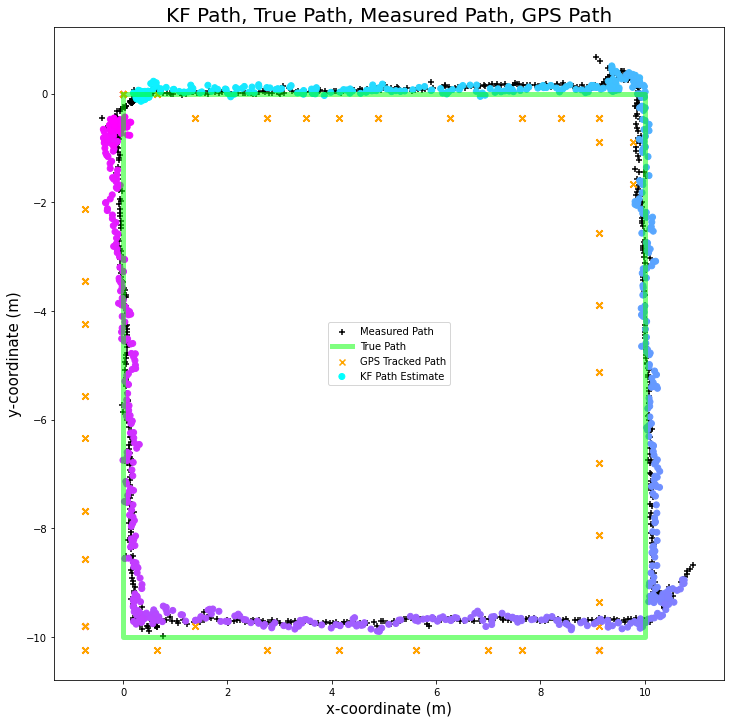

In [27]:
num_state_points = state_estimates.shape[2]
state_cmap = matplotlib.cm.get_cmap('cool')

plt.figure(figsize = (12,12))
plt.scatter(z_x, z_y, color = 'black', label = 'Measured Path', marker = '+')
plt.plot([0,10, 10, 0, 0], [0, 0, -10, -10, 0], linewidth = 5, color = 'lime', label = 'True Path', alpha = 0.5)
plt.scatter(gps_estimates[0,:], gps_estimates[1,:], label = 'GPS Tracked Path', color = 'orange', marker = 'x')
plt.scatter(pf_x, pf_y, c = state_cmap(np.linspace(0,1,num_state_points)), label = 'KF Path Estimate', marker = 'o')

# for n in range(8):
#     ax = plt.gca()
#     ax.set_aspect('equal')
#     ellipse = Ellipse((state_estimates[0][100*n],state_estimates[1][100*n]),width = np.sqrt(covariance_estimates[0][0][100*n])*2,height = np.sqrt(covariance_estimates[1][1][100*n])*2, facecolor = 'none', edgecolor = 'blue')
#     ax.add_patch(ellipse)
plt.legend()

plt.title('PF Path, True Path, Measured Path, GPS Path', fontsize = 20)
plt.xlabel('x-coordinate (m)', fontsize = 15)
plt.ylabel('y-coordinate (m)', fontsize = 15)

plt.show()

In [ ]:
plt.figure(figsize = (10,8))
for p_ind in range(PARTICLES):
    plt.plot(z_x, z_y)
    zp = state_estimates[p_ind,0:2,:]
    plt.scatter(zp[0,:],zp[1,:])

#plt.xlim(-1,5)
#plt.ylim(-5,1)

In [ ]:
state_est_t.shape

In [ ]:
state_est_t = rng.choice(a = state_pred_t, 
                     size = PARTICLES, 
                     p = state_pred_t[:,5],
                     axis = 0)

In [ ]:
state_pred_t

In [ ]:
state_pred_t[:,5]